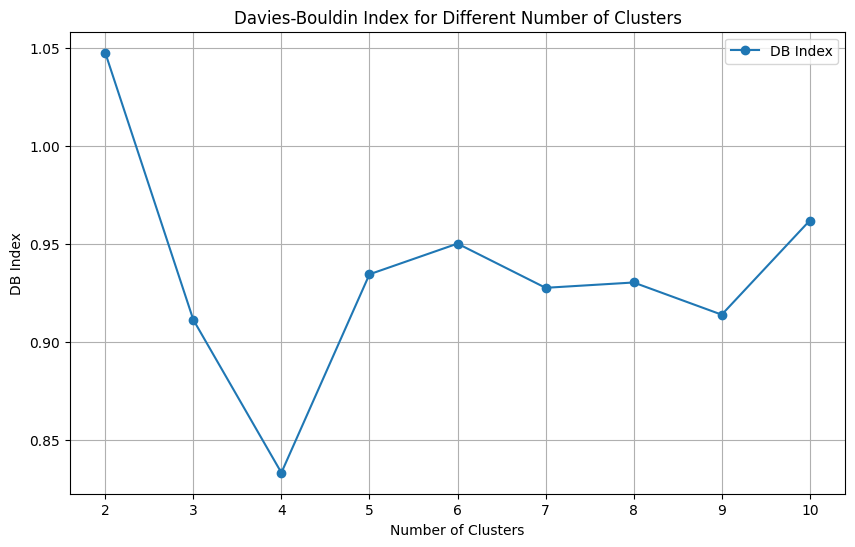

Optimal number of clusters: 4
Minimum DB Index: 0.833
Silhouette Score: 0.364
Segmentation results saved to 'Customer_Segmentation.csv'.


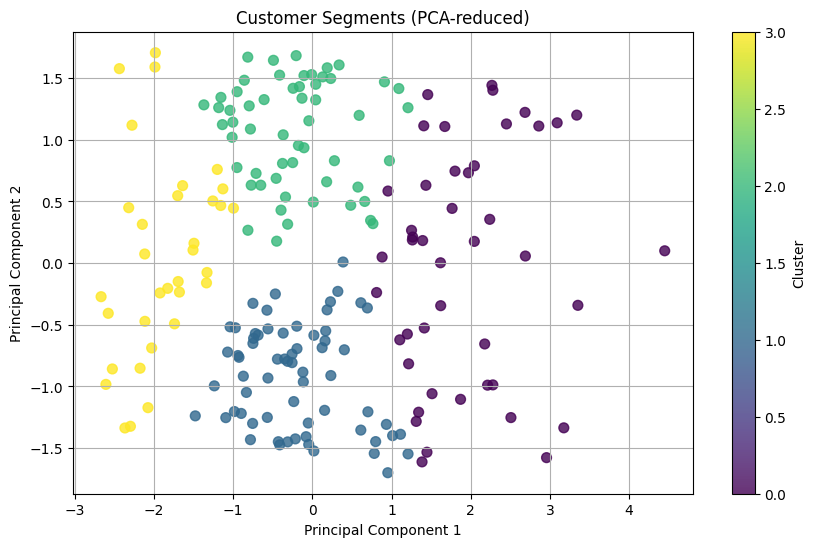


Number of Clusters: 4
Davies-Bouldin Index: 0.833
Silhouette Score: 0.364

Cluster Summary (Example Output):
         TotalValue  Quantity  CustomerDuration
Cluster                                        
0           5975.34     21.16            602.69
1           3291.94     12.22            254.54
2           3084.63     11.46            894.91
3           1042.12      4.52            523.88



In [4]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load the datasets
customers = pd.read_csv(r'/home/Customers.csv')
products = pd.read_csv(r'/home/Products.csv')
transactions = pd.read_csv(r'/home/Transactions.csv')

# Sample data preprocessing
merged_data = transactions.merge(products, on='ProductID').merge(customers, on='CustomerID')
merged_data['SignupDate'] = pd.to_datetime(merged_data['SignupDate'])
merged_data['CustomerDuration'] = (pd.Timestamp.now() - merged_data['SignupDate']).dt.days
customer_agg = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'CustomerDuration': 'mean'
}).reset_index()

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_agg[['TotalValue', 'Quantity', 'CustomerDuration']])

# Find the optimal number of clusters using Davies-Bouldin Index
db_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_data)
    db_score = davies_bouldin_score(scaled_data, labels)
    db_scores.append(db_score)

# Plot Davies-Bouldin Index
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), db_scores, marker='o', label='DB Index')
plt.title('Davies-Bouldin Index for Different Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.legend()
plt.grid()
plt.show()

# Choose the optimal number of clusters
optimal_clusters = db_scores.index(min(db_scores)) + 2
print(f"Optimal number of clusters: {optimal_clusters}")
print(f"Minimum DB Index: {min(db_scores):.3f}")

# Final clustering with optimal clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
final_labels = kmeans.fit_predict(scaled_data)
customer_agg['Cluster'] = final_labels

# Silhouette Score for cluster quality
sil_score = silhouette_score(scaled_data, final_labels)
print(f"Silhouette Score: {sil_score:.3f}")

# Save final segmented customers
customer_agg.to_csv('Customer_Segmentation.csv', index=False)
print("Segmentation results saved to 'Customer_Segmentation.csv'.")

# Visualize clusters (first two principal components)
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)
plt.figure(figsize=(10, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=final_labels, cmap='viridis', s=50, alpha=0.8)
plt.colorbar(label='Cluster')
plt.title('Customer Segments (PCA-reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()

# Final Report Output
report = f"""
Number of Clusters: {optimal_clusters}
Davies-Bouldin Index: {min(db_scores):.3f}
Silhouette Score: {sil_score:.3f}

Cluster Summary (Example Output):
{customer_agg.groupby('Cluster').agg({
    'TotalValue': 'mean',
    'Quantity': 'mean',
    'CustomerDuration': 'mean'
}).round(2)}
"""
print(report)
